# Fully Flexible Resampling (Vorobets 2025), Sacked Portfolio Risk Manager, and Regime Tilting (Tactical) Optimizer

## Fully Flexible Resampling
States variables: Growth (S&P500), VIX, Real Rates, Inflation.
The first two are high/mid/low, the rest are high/low partitioned.

In [2]:
#!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn yfinance fredapi

In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
from fredapi import Fred
import fortitudo.tech as ft
import matplotlib.pyplot as plt
import seaborn as sns

fred = Fred(api_key='f887507374b463ac1fcc8e0ad01cbed3')

In [17]:
########### NEW DATA FETCHING CHUNK ########### 

In [18]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

selected_assets = [
    'NVDA', 'ISRG', 'APO', 'DECK', 'COST', 'CAT', 
    'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]

data = data[[t for t in selected_assets if t in data.columns]]
data_clean = data.dropna(axis=0, how='any')

start_date = data_clean.index[0]
end_date = data_clean.index[-1]

sp500_raw = yf.download('^GSPC', start=start_date, end=end_date, progress=False, auto_adjust=True)
sp500 = sp500_raw['Close']['^GSPC'] if isinstance(sp500_raw.columns, pd.MultiIndex) else sp500_raw['Close']

vix_raw = yf.download('^VIX', start=start_date, end=end_date, progress=False, auto_adjust=True)
vix = vix_raw['Close']['^VIX'] if isinstance(vix_raw.columns, pd.MultiIndex) else vix_raw['Close']

real_rate = fred.get_series('DFII10', start_date, end_date)
inflation = fred.get_series('T10YIE', start_date, end_date)

state_vars = pd.DataFrame({
    'SP500': sp500,
    'VIX': vix,
    'RealRate': real_rate,
    'Inflation': inflation
}).reindex(data_clean.index).ffill().dropna()

state_vars['SP500_ret'] = np.log(state_vars['SP500'] / state_vars['SP500'].shift(1))
state_vars = state_vars.drop(columns='SP500').dropna()

common_dates = data_clean.index.intersection(state_vars.index)
asset_data = data_clean.loc[common_dates]
state_vars = state_vars.loc[common_dates]

pnl = np.log(asset_data / asset_data.shift(1)).dropna()
state_vars = state_vars.loc[pnl.index]

print(f"Assets: {asset_data.shape[1]} | Days: {len(pnl)}")
print(f"Range: {pnl.index[0].date()} → {pnl.index[-1].date()}")
print(f"{len(pnl)/252:.1f} years of data")

Assets: 12 | Days: 2469
Range: 2016-01-06 → 2025-11-11
9.8 years of data


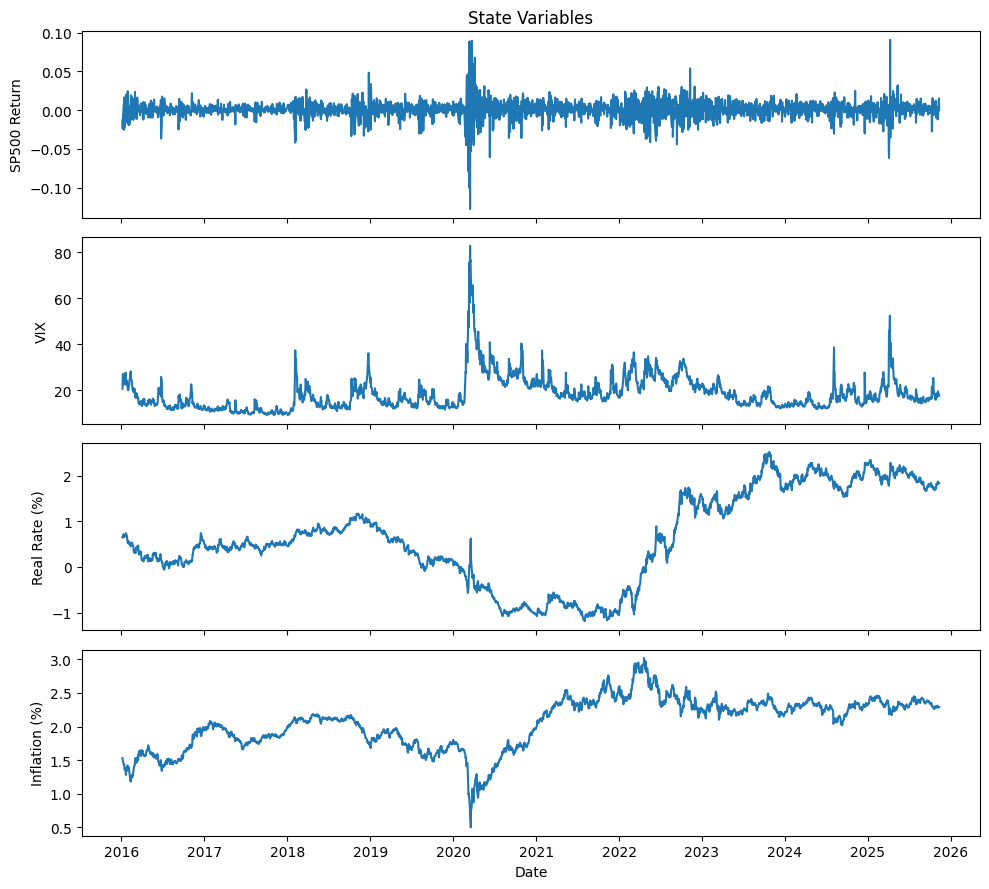

In [19]:
fig, axes = plt.subplots(4, 1, figsize=(10, 9), sharex=True)

axes[0].plot(state_vars['SP500_ret'])
axes[0].set_ylabel('SP500 Return')
axes[0].set_title('State Variables')

axes[1].plot(state_vars['VIX'])
axes[1].set_ylabel('VIX')

axes[2].plot(state_vars['RealRate'])
axes[2].set_ylabel('Real Rate (%)')

axes[3].plot(state_vars['Inflation'])
axes[3].set_ylabel('Inflation (%)')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [20]:
def classify_3(series):
    p25 = np.percentile(series, 25)
    p75 = np.percentile(series, 75)
    return np.where(series <= p25, 0, np.where(series <= p75, 1, 2))

def classify_2(series):
    med = np.median(series)
    return np.where(series <= med, 0, 1)

regimes = pd.DataFrame({
    'growth': classify_3(state_vars['SP500_ret']),
    'vix': classify_3(state_vars['VIX']),
    'real_rate': classify_2(state_vars['RealRate']),
    'inflation': classify_2(state_vars['Inflation'])
}, index=state_vars.index)

regimes['state'] = regimes['growth'] + 3*regimes['vix'] + 9*regimes['real_rate'] + 18*regimes['inflation']

print(f"Possible states: {3*3*2*2}")
print(f"Observed states: {regimes['state'].nunique()}")
print(f"Min obs per state: {regimes['state'].value_counts().min()}")
print(f"\nState distribution:")
print(regimes['state'].value_counts().sort_index())

Possible states: 36
Observed states: 33
Min obs per state: 8

State distribution:
state
0      20
1     286
2      48
3      66
4     146
5      68
6      86
7      65
8      89
9      10
10     97
11     22
12     56
13     82
14     56
15     35
16     12
17     14
21     37
22    126
23     58
24     76
25     30
26     42
27      8
28     98
29     29
30    142
31    255
32    142
33     82
34     37
35     49
Name: count, dtype: int64


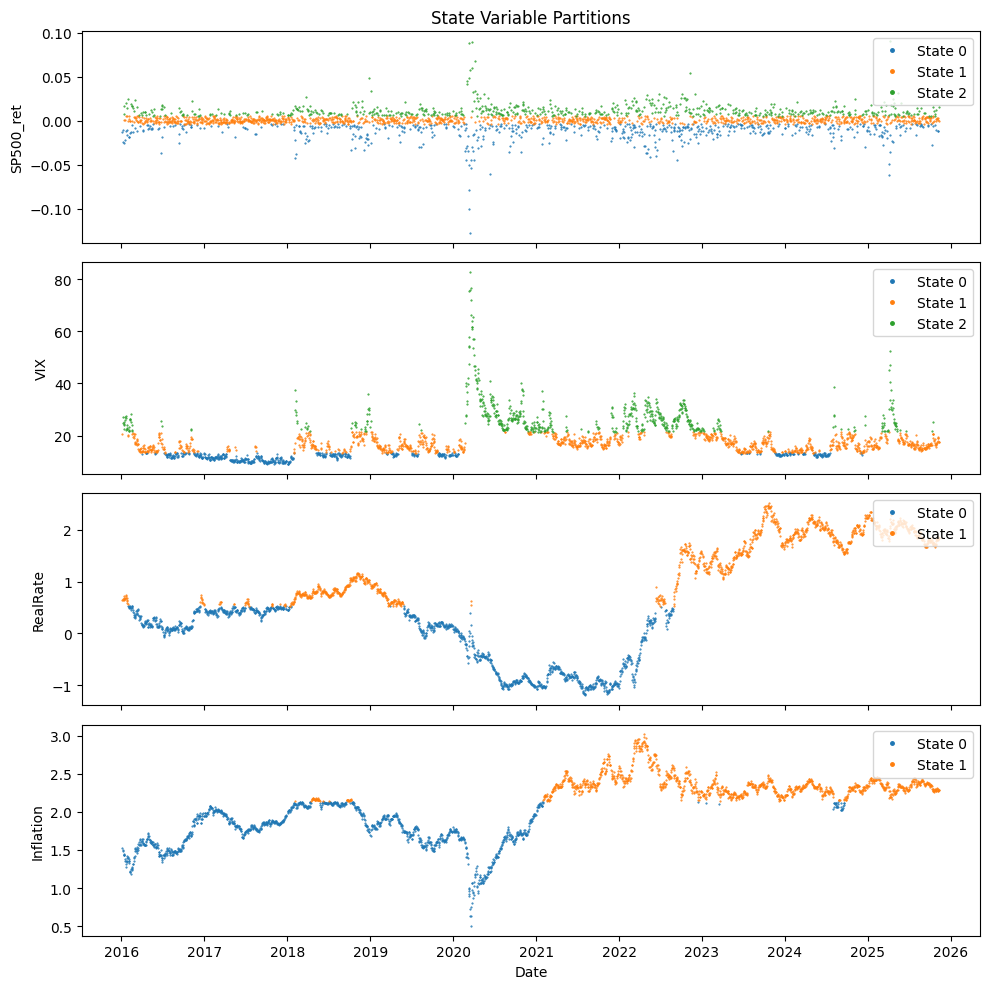

In [21]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

colors = ['tab:blue', 'tab:orange', 'tab:green']

for ax, (var, n_states) in zip(axes, [('SP500_ret', 3), ('VIX', 3), ('RealRate', 2), ('Inflation', 2)]):
    series = state_vars[var].values
    regime = regimes[var.lower().replace('_ret', '').replace('rate', '_rate')].values if var != 'SP500_ret' else regimes['growth'].values
    
    for s in range(n_states):
        mask = regime == s
        masked = np.where(mask, series, np.nan)
        ax.plot(state_vars.index, masked, '.', color=colors[s], markersize=1, label=f'State {s}')
    
    ax.set_ylabel(var)
    ax.legend(loc='upper right', markerscale=5)

axes[0].set_title('State Variable Partitions')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

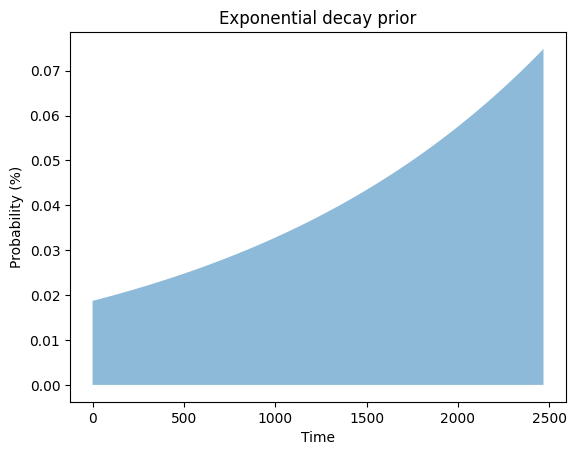

In [22]:
T = len(pnl)
p_exp = ft.exp_decay_probs(pnl, half_life=T/2)

plt.figure()
plt.fill_between(range(T), p_exp.flatten() * 100, alpha=0.5)
plt.ylabel('Probability (%)')
plt.xlabel('Time')
plt.title('Exponential decay prior')
plt.show()

In [23]:
n_states = 36
state_means = np.zeros((n_states, 4))
state_stds = np.zeros((n_states, 4))

state_var_cols = ['SP500_ret', 'VIX', 'RealRate', 'Inflation']
state_vals = state_vars[state_var_cols].values

for s in range(n_states):
    mask = regimes['state'].values == s
    if mask.sum() > 0:
        state_means[s] = np.mean(state_vals[mask], axis=0)
        state_stds[s] = np.std(state_vals[mask], axis=0)

observed_states = regimes['state'].unique()
print(f"Observed states: {len(observed_states)}")
print(f"Missing states: {set(range(n_states)) - set(observed_states)}")

Observed states: 33
Missing states: {18, 19, 20}


In [24]:
state_probs = {}

for s in observed_states:
    mu_s = state_means[s]
    sigma_s = state_stds[s]
    
    A = np.vstack((np.ones((1, T)), state_vals.T))
    b = np.vstack(([[1]], mu_s[:, np.newaxis]))
    
    G = state_vals.T ** 2
    h = (sigma_s ** 2 + mu_s ** 2)[:, np.newaxis]
    
    try:
        q = ft.entropy_pooling(p_exp, A, b, G, h)
        state_probs[s] = q.flatten()
    except:
        state_probs[s] = p_exp.flatten()
        print(f"State {s}: entropy pooling failed, using prior")

print(f"Computed probability vectors for {len(state_probs)} states")

/usr/local/lib/python3.11/dist-packages/fortitudo/tech/entropy_pooling.py:78: RuntimeWarning: overflow encountered in exp
  x = np.exp(log_x)
/usr/local/lib/python3.11/dist-packages/fortitudo/tech/entropy_pooling.py:79: RuntimeWarning: invalid value encountered in matmul
  gradient = rhs - lhs @ x
/usr/local/lib/python3.11/dist-packages/fortitudo/tech/entropy_pooling.py:80: RuntimeWarning: overflow encountered in matmul
  objective = x.T @ (log_x - log_p) - lagrange_multipliers.T @ gradient
/usr/local/lib/python3.11/dist-packages/fortitudo/tech/entropy_pooling.py:80: RuntimeWarning: invalid value encountered in matmul
  objective = x.T @ (log_x - log_p) - lagrange_multipliers.T @ gradient


Computed probability vectors for 33 states


/usr/local/lib/python3.11/dist-packages/fortitudo/tech/entropy_pooling.py:79: RuntimeWarning: overflow encountered in matmul
  gradient = rhs - lhs @ x


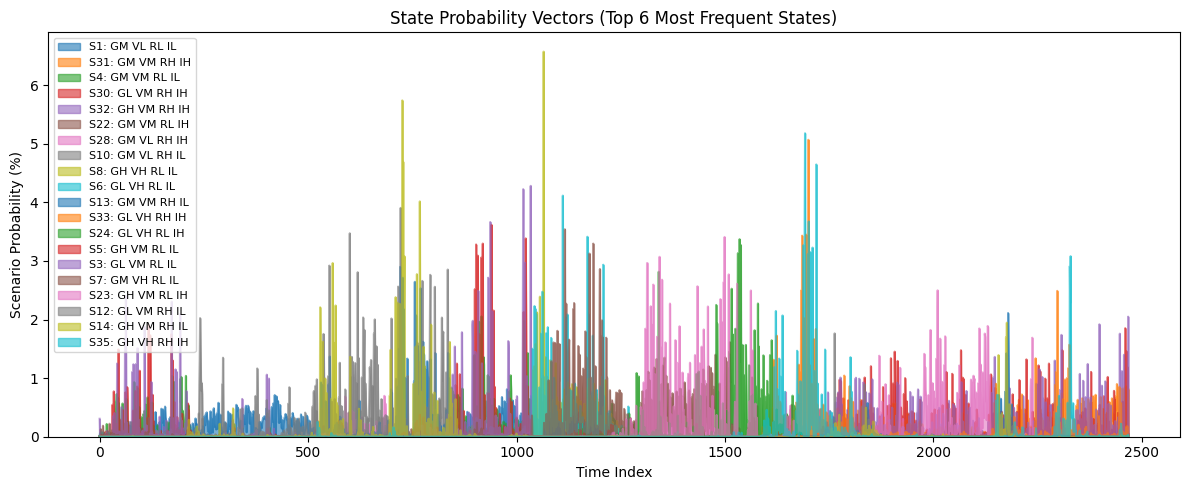

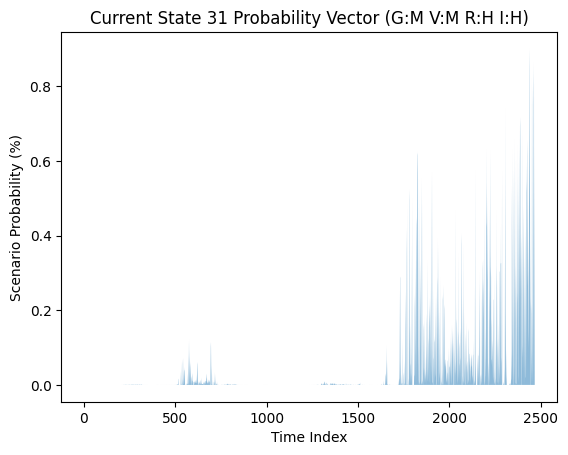

In [31]:
top_n = 20  
top_states = regimes['state'].value_counts().head(top_n).index.tolist()

prob_df = pd.DataFrame(index=range(T))
for s in top_states:
    g = s % 3
    v = (s // 3) % 3
    r = (s // 9) % 2
    i = (s // 18) % 2
    label = f"S{s}: G{['L','M','H'][g]} V{['L','M','H'][v]} R{['L','H'][r]} I{['L','H'][i]}"
    prob_df[label] = state_probs[s] / state_probs[s].sum() * 100

fig, ax = plt.subplots(figsize=(12, 5))
prob_df.plot(kind='area', stacked=False, alpha=0.6, ax=ax)
ax.set_title('State Probability Vectors (Top 6 Most Frequent States)')
ax.set_xlabel('Time Index')
ax.set_ylabel('Scenario Probability (%)')
ax.legend(loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Current State
current_state = states_vector[-1]
g = current_state % 3
v = (current_state // 3) % 3
r = (current_state // 9) % 2
i = (current_state // 18) % 2

plt.figure()
plt.fill_between(range(T), state_probs[current_state] / state_probs[current_state].sum() * 100, alpha=0.5)
plt.title(f'Current State {current_state} Probability Vector (G:{["L","M","H"][g]} V:{["L","M","H"][v]} R:{["L","H"][r]} I:{["L","H"][i]})')
plt.xlabel('Time Index')
plt.ylabel('Scenario Probability (%)')
plt.show()

In [26]:
states_vector = regimes['state'].values
states_prob = np.zeros((T, n_states))

for s in observed_states:
    states_prob[:, s] = state_probs[s] / state_probs[s].sum()

current_state = states_vector[-1]
current_regimes = regimes.iloc[-1]

print(f"States probability matrix: {states_prob.shape}")
print(f"Current state: {current_state}")
print(f"  Growth:    {['Low', 'Mid', 'High'][current_regimes['growth']]}")
print(f"  VIX:       {['Low', 'Mid', 'High'][current_regimes['vix']]}")
print(f"  Real Rate: {['Low', 'High'][current_regimes['real_rate']]}")
print(f"  Inflation: {['Low', 'High'][current_regimes['inflation']]}")

States probability matrix: (2469, 36)
Current state: 31
  Growth:    Mid
  VIX:       Mid
  Real Rate: High
  Inflation: High


## Stacked Portfolio's Risk Manager
The stacked weights are defiend in a differnet file 

In [89]:
target_weights = np.array([
    0.0426,  # NVDA
    0.0529,  # ISRG
    0.0398,  # APO
    0.0570,  # DECK ← moved here
    0.1556,  # COST
    0.0935,  # CAT
    0.0297,  # BTU
    0.1022,  # SHW
    0.0757,  # NRG
    0.0686,  # NFLX
    0.0532,  # CBRE
    0.2292   # GC=F
])

print("Assets and weights:")
for name, w in zip(pnl.columns, target_weights):
    print(f"  {name:6s} {w*100:5.2f}%")
print(f"\nSum: {target_weights.sum()*100:.1f}%")

Assets and weights:
  NVDA    4.26%
  ISRG    5.29%
  APO     3.98%
  DECK    5.70%
  COST   15.56%
  CAT     9.35%
  BTU     2.97%
  SHW    10.22%
  NRG     7.57%
  NFLX    6.86%
  CBRE    5.32%
  GC=F   22.92%

Sum: 100.0%


In [90]:
H = 21
S = 10000
np.random.seed(0)

def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

current_state = states_vector[-1]
sim_idx = resampling(S, H, current_state, states_prob, states_vector)

print(f"Simulation shape: {sim_idx.shape}")
print(f"Initial state: {current_state}")

Simulation shape: (10000, 21)
Initial state: 31


In [91]:
port_sim = np.full((S, H), np.nan)

for s in range(S):
    port_sim[s, :] = (pnl.values[sim_idx[s, :]] @ target_weights)

port_cum = np.exp(np.cumsum(port_sim, axis=1)) - 1

print(f"Portfolio cumulative returns shape: {port_cum.shape}")

Portfolio cumulative returns shape: (10000, 21)


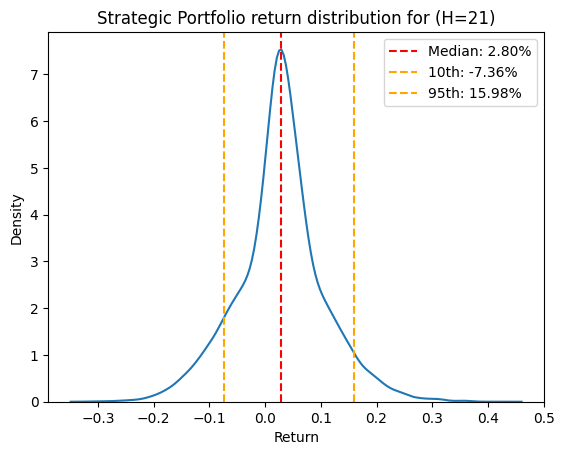

In [92]:
sns.kdeplot(port_cum[:, -1])
plt.axvline(np.median(port_cum[:, -1]), color='red', linestyle='--', label=f'Median: {np.median(port_cum[:, -1])*100:.2f}%')
plt.axvline(np.percentile(port_cum[:, -1], 10), color='orange', linestyle='--', label=f'10th: {np.percentile(port_cum[:, -1], 10)*100:.2f}%')
plt.axvline(np.percentile(port_cum[:, -1], 95), color='orange', linestyle='--', label=f'95th: {np.percentile(port_cum[:, -1], 95)*100:.2f}%')
plt.title(f'Strategic Portfolio return distribution for (H={H})')
plt.xlabel('Return')
plt.legend()
plt.show()

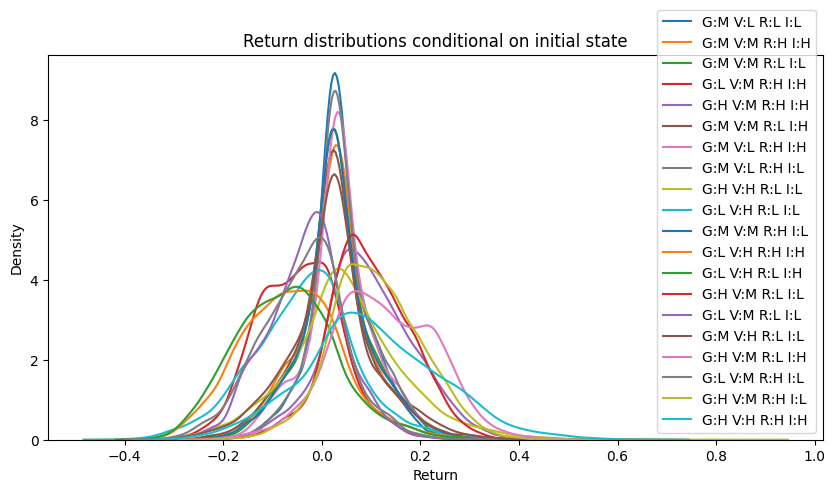

In [93]:
top_states = regimes['state'].value_counts().head(20).index.tolist()

fig, ax = plt.subplots(figsize=(10, 5))

for s in top_states:
    sim_s = resampling(S, H, s, states_prob, states_vector)
    port_s = np.full((S, H), np.nan)
    for i in range(S):
        port_s[i, :] = pnl.values[sim_s[i, :]] @ target_weights
    port_cum_s = np.exp(np.cumsum(port_s, axis=1)) - 1
    
    g = s % 3
    v = (s // 3) % 3
    r = (s // 9) % 2
    i_s = (s // 18) % 2
    label = f'G:{["L","M","H"][g]} V:{["L","M","H"][v]} R:{["L","H"][r]} I:{["L","H"][i_s]}'
    sns.kdeplot(port_cum_s[:, -1], label=label)

plt.title('Return distributions conditional on initial state')
plt.xlabel('Return')
plt.legend()
plt.show()

In [94]:
num_states = states_prob.shape[1]
transition_matrix = np.full((num_states, num_states), np.nan)

for row_state in observed_states:
    for col_state in observed_states:
        transition_matrix[row_state, col_state] = np.sum(states_prob[states_vector == col_state, row_state])

print("Transition matrix (top 5x5 of observed states):")
top_5 = sorted(observed_states)[:5]
df_trans = pd.DataFrame(
    transition_matrix[np.ix_(top_5, top_5)],
    index=[f'From {s}' for s in top_5],
    columns=[f'To {s}' for s in top_5]
)
print(np.round(df_trans, 3))

Transition matrix (top 5x5 of observed states):
         To 0   To 1   To 2   To 3   To 4
From 0  0.593  0.243  0.000  0.055  0.010
From 1  0.018  0.859  0.027  0.002  0.040
From 2  0.000  0.109  0.729  0.000  0.003
From 3  0.020  0.026  0.000  0.802  0.093
From 4  0.003  0.113  0.002  0.042  0.721


In [95]:
alpha = 0.9
cutoff = int((1 - alpha) * S)
sorted_returns = np.sort(port_cum[:, -1])
cvar_90 = -np.mean(sorted_returns[:cutoff])
var_90 = -np.percentile(port_cum[:, -1], (1 - alpha) * 100)

period = f"{H}d"
print(f"{period} Return Distribution:")
print(f"  Median: {np.median(port_cum[:, -1])*100:.2f}%")
print(f"  VaR 90%: {var_90*100:.2f}%")
print(f"  CVaR 90%: {cvar_90*100:.2f}%")

21d Return Distribution:
  Median: 2.80%
  VaR 90%: 7.36%
  CVaR 90%: 11.81%


In [96]:
equity = 300000
risk_budget = 0.10

max_leverage = risk_budget / cvar_90
max_position = equity * max_leverage

print(f"Equity: ${equity:,.0f}")
print(f"Risk budget: {risk_budget*100:.0f}%")
print(f"CVaR 90% ({H}d): {cvar_90*100:.2f}%")
print(f"Max leverage: {max_leverage:.2f}x")
print(f"Max position: ${max_position:,.0f}")

Equity: $300,000
Risk budget: 10%
CVaR 90% (21d): 11.81%
Max leverage: 0.85x
Max position: $254,011


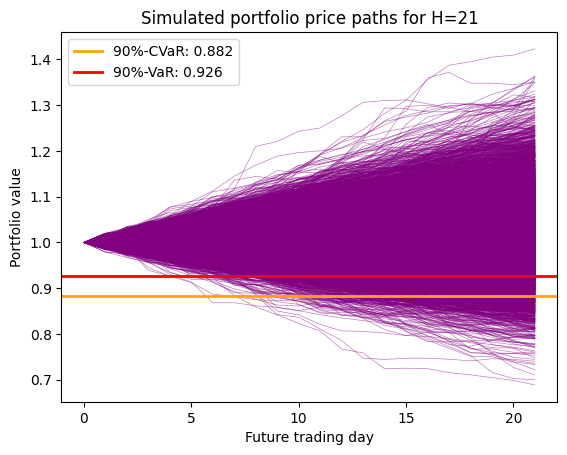

In [97]:
wealth_paths = np.hstack([np.ones((S, 1)), 1 + port_cum])

plt.figure()
plt.plot(wealth_paths.T, color='purple', alpha=0.50, linewidth=0.5)
plt.axhline(1 - cvar_90, color='orange', linewidth=2, label=f'90%-CVaR: {(1-cvar_90):.3f}')
plt.axhline(1 - var_90, color='red', linewidth=2, label=f'90%-VaR: {(1-var_90):.3f}')
plt.xlabel('Future trading day')
plt.ylabel('Portfolio value')
plt.title(f'Simulated portfolio price paths for H={H}')
plt.legend()
plt.show()

## Portfolio Optimisation for Posterior

In [98]:
current_state = states_vector[-1]
q_posterior = states_prob[:, current_state]
q_posterior = q_posterior[:, np.newaxis]

I = pnl.shape[1]
G = np.vstack((np.eye(I), -np.eye(I)))
h = np.hstack((0.25 * np.ones(I), 0.25 * np.ones(I)))

cvar_opt_post = ft.MeanCVaR(pnl.values, G, h, alpha=0.9, p=q_posterior)
return_target = float(np.mean(pnl.values * q_posterior * T, axis=0).sum() / I)
e_opt_post = np.array(cvar_opt_post.efficient_portfolio(return_target)).flatten()

print("Posterior optimal weights vs target:")
for name, w_post, w_tgt in zip(pnl.columns, e_opt_post, target_weights):
    print(f"  {name:6s}  {w_post*100:6.2f}%  vs  {w_tgt*100:5.2f}%")

Posterior optimal weights vs target:
  NVDA     10.59%  vs   4.26%
  ISRG      7.44%  vs   5.29%
  APO       5.67%  vs   3.98%
  DECK      2.54%  vs   5.70%
  COST     18.36%  vs  15.56%
  CAT      20.32%  vs   9.35%
  BTU       0.18%  vs   2.97%
  SHW      11.41%  vs  10.22%
  NRG       6.49%  vs   7.57%
  NFLX      5.95%  vs   6.86%
  CBRE     -1.02%  vs   5.32%
  GC=F     12.06%  vs  22.92%


In [99]:
H = 21
S = 10000
np.random.seed(0)

def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

current_state = states_vector[-1]
sim_idx = resampling(S, H, current_state, states_prob, states_vector)

print(f"Simulation shape: {sim_idx.shape}")
print(f"Initial state: {current_state}")

Simulation shape: (10000, 21)
Initial state: 31


In [100]:
port_sim = np.full((S, H), np.nan)

for s in range(S):
    port_sim[s, :] = (pnl.values[sim_idx[s, :]] @ e_opt_post)

port_cum = np.exp(np.cumsum(port_sim, axis=1)) - 1

print(f"Portfolio cumulative returns shape: {port_cum.shape}")

Portfolio cumulative returns shape: (10000, 21)


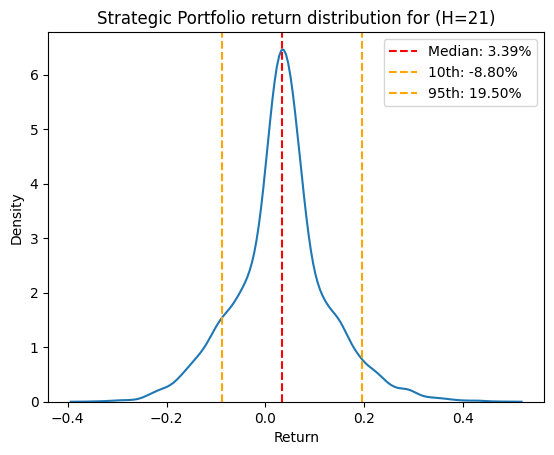

In [101]:
import seaborn as sns

sns.kdeplot(port_cum[:, -1])
plt.axvline(np.median(port_cum[:, -1]), color='red', linestyle='--', label=f'Median: {np.median(port_cum[:, -1])*100:.2f}%')
plt.axvline(np.percentile(port_cum[:, -1], 10), color='orange', linestyle='--', label=f'10th: {np.percentile(port_cum[:, -1], 10)*100:.2f}%')
plt.axvline(np.percentile(port_cum[:, -1], 95), color='orange', linestyle='--', label=f'95th: {np.percentile(port_cum[:, -1], 95)*100:.2f}%')
plt.title(f'Strategic Portfolio return distribution for (H={H})')
plt.xlabel('Return')
plt.legend()
plt.show()

In [102]:
alpha = 0.9
cutoff = int((1 - alpha) * S)
sorted_returns = np.sort(port_cum[:, -1])
cvar_90 = -np.mean(sorted_returns[:cutoff])
var_90 = -np.percentile(port_cum[:, -1], (1 - alpha) * 100)

period = f"{H}d"
print(f"{period} Return Distribution:")
print(f"  Median: {np.median(port_cum[:, -1])*100:.2f}%")
print(f"  VaR 90%: {var_90*100:.2f}%")
print(f"  CVaR 90%: {cvar_90*100:.2f}%")

21d Return Distribution:
  Median: 3.39%
  VaR 90%: 8.80%
  CVaR 90%: 13.99%


In [103]:
equity_tct = 150000
risk_budget_tct = 0.10

max_leverage_tct = risk_budget_tct / cvar_90
max_position_tct = equity_tct * max_leverage_tct

print(f"Equity: ${equity_tct:,.0f}")
print(f"Risk budget: {risk_budget_tct*100:.0f}%")
print(f"CVaR 90% ({H}d): {cvar_90*100:.2f}%")
print(f"Max leverage: {max_leverage_tct:.2f}x")
print(f"Max position: ${max_position_tct:,.0f}")

Equity: $150,000
Risk budget: 10%
CVaR 90% (21d): 13.99%
Max leverage: 0.71x
Max position: $107,188


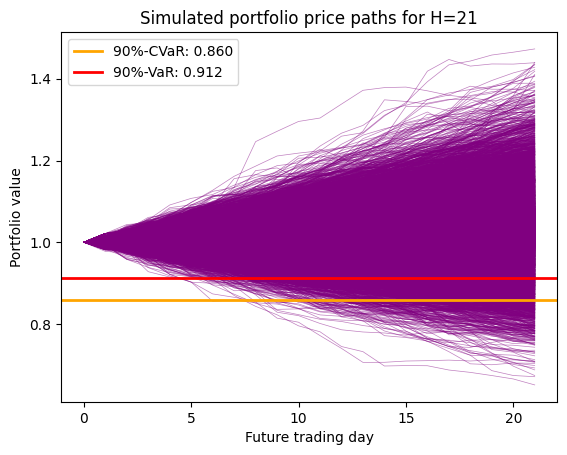

In [104]:
wealth_paths = np.hstack([np.ones((S, 1)), 1 + port_cum])

plt.figure()
plt.plot(wealth_paths.T, color='purple', alpha=0.50, linewidth=0.5)
plt.axhline(1 - cvar_90, color='orange', linewidth=2, label=f'90%-CVaR: {(1-cvar_90):.3f}')
plt.axhline(1 - var_90, color='red', linewidth=2, label=f'90%-VaR: {(1-var_90):.3f}')
plt.xlabel('Future trading day')
plt.ylabel('Portfolio value')
plt.title(f'Simulated portfolio price paths for H={H}')
plt.legend()
plt.show()

## Combined Maximum Loss